In [17]:
#@title Install
!pip install torchviz

In [15]:
#@title Imports
import zipfile
import os
import torchvision.models as models
import torch.nn as nn
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
from torchviz import make_dot
from sklearn.metrics import roc_auc_score

In [7]:
#@title drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#@title Préparation des fichiers Odir
# Chemin du fichier ZIP
zip_path = "/content/drive/My Drive/Odir_ent.zip"
extract_path = "/content/Odir_ent"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Fichiers extraits dans {extract_path}")
import os

num_files = sum([len(files) for _, _, files in os.walk(extract_path)])
print(f"Nombre total de fichiers extraits : {num_files}")

zip_path = "/content/drive/My Drive/ODIR.zip"
extract_path = "/content/ODIR"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Fichiers extraits dans {extract_path}")

Fichiers extraits dans /content/Odir_ent
Nombre total de fichiers extraits : 7000
Fichiers extraits dans /content/ODIR


#Model Resnet_50

In [10]:
#@title Test Resnet_50 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
print(num_ftrs)
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs//2),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(num_ftrs//2,num_ftrs//4 ),
    nn.ReLU(),
    nn.Linear(num_ftrs//4,8))
model.to(device=device)
summary(model, (3, 244, 244))

model.load_state_dict(torch.load('/content/model.pt', map_location=torch.device('cpu')), strict=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)



Using device cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s]


2048
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1,

In [ ]:
#@title Model architecture
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs // 2),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(num_ftrs // 2, num_ftrs // 4),
    nn.ReLU(),
    nn.Linear(num_ftrs // 4, 8)
)
x = torch.randn(1, 3, 224, 224)
y = model(x)
dot = make_dot(y, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('model_architecture')

In [11]:
#@title Augmentation
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_1=transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
#@title Class Riad
from PIL import Image
import os
import ast
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
#Les images
image_dir_ent = '/content/drive/MyDrive/Riad/Training/Training'
image_dir_val = '/content/drive/MyDrive/Riad/Validation/Validation'
image_dir_tes = '/content/drive/MyDrive/Riad/Test/Test'

# Chargement du fichier CSV
df_ent = pd.read_csv('/content/drive/MyDrive/Riad/RFMiD_Training_with_vecteur.csv')
df_val = pd.read_csv('/content/drive/MyDrive/Riad/RFMiD_Validation_with_vecteur.csv')
df_tes = pd.read_csv('/content/drive/MyDrive/Riad/RFMiD_Testing_with_vecteur.csv')

# Transformation des images pour les préparer à ResNet

#Dataset_riad
class Riad_Dataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = f"{idx+1}"
        img_name = os.path.join(self.image_dir, f"{img_id}.png")

        image = Image.open(img_name)
        label = self.df.loc[self.df['ID'] == int(img_id), 'vecteur'].values[0]
        label = ast.literal_eval(label)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)
train_dataset = Riad_Dataset(csv_file='/content/drive/MyDrive/Riad/RFMiD_Training_with_vecteur.csv', image_dir=image_dir_ent, transform=transform)
val_dataset = Riad_Dataset(csv_file='/content/drive/MyDrive/Riad/RFMiD_Validation_with_vecteur.csv', image_dir=image_dir_val, transform=transform)
test_dataset = Riad_Dataset(csv_file='/content/drive/MyDrive/Riad/RFMiD_Testing_with_vecteur.csv', image_dir=image_dir_tes, transform=transform_1)

# Data_loader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=4)
valid_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.numpy().shape)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(16, 3, 244, 244)


In [14]:
#@title Training without fishr
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):
  for param in model.features.parameters():
    param.requires_grad = False

  train_losses, valid_losses = [], []
  valid_loss_min = np.Inf

  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0

      model.train()
      for i, (data, label) in enumerate(train_loader):
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.float32)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()

        if (i + 1) % 10 == 0:
            optimizer.step()
            optimizer.zero_grad()

      model.eval()
      for data, label in valid_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          #print(label)
          output = model(data)
          loss = criterion(output, label)
          valid_loss += loss.item()*data.size(0)


      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss

  return train_losses, valid_losses
train_losses, valid_losses= training(10, train_loader, valid_loader, model, criterion, optimizer)

In [ ]:
#@title Evaluate without fishr
def evaluate_model_with_auc(model, test_loader, device):

    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            all_outputs.append(output.cpu().numpy())
            all_labels.append(label.cpu().numpy())

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    auc_per_class = roc_auc_score(all_labels, all_outputs, average=None)
    auc_per_class_0=[]
    for i in range(1,8):
      if i!=5:
        auc_per_class_0.append(auc_per_class[i])

    auc=[]
    for i in range(8):
      if i!=5:
       auc.append(auc_per_class[i])
    mean_auc = np.mean(auc)

    return auc_per_class_0, mean_auc
auc_per_class, mean_auc = evaluate_model_with_auc(model,test_loader, device)

print("AUC per class:", auc_per_class)
print("Mean AUC:", mean_auc)

#Fishr

In [ ]:
#@title Class Odir
#Les images
image_odir_train_vald= '/content/Odir_ent/Images'
image_odir_off_test = '/content/ODIR/Off-site_TestSet'
image_odir_on_test = '/content/ODIR/On-site_TestSet/Images'
# Chargement du fichier CSV
df_odir_entt = pd.read_csv('/content/drive/MyDrive/Odir/Odir_Training_with_vecteur.csv')
X=df_odir_entt.drop(columns=['vecteur'])
y=df_odir_entt['vecteur']
df_odir_ent,df_odir_val,y_odir_ent,y_odir_val=train_test_split(X, y, test_size=0.3, random_state=42)
df_odir_ent['vecteur'] = y_odir_ent
df_odir_val['vecteur'] = y_odir_val
########################################################################################################""
df_odir_ent.to_csv('Odir_Training_with_vecteur.csv', index=False)
df_odir_val.to_csv('Odir_validation_with_vecteur.csv', index=False)
df_odir_off_test = pd.read_csv('/content/drive/MyDrive/Odir/Odir_test_off_with_vecteur.csv')
df_odir_on_test = pd.read_csv('/content/drive/MyDrive/Odir/Odir_test_on_with_vecteur.csv')

# Transformation des images pour les préparer à ResNet

#Dataset_ODIR
class Odir_Dataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
     img_id = self.df.iloc[idx]['ID']  # Exemple : "808_left" ou "490_right"

    # Construction du chemin de l'image
     img_name = os.path.join(self.image_dir, f"{img_id}.jpg")

    # Chargement de l'image
     image = Image.open(img_name)

    # Récupération de l'étiquette
     label = self.df.loc[self.df['ID'] == img_id, 'vecteur'].values[0]
     label = ast.literal_eval(label)

    # Application des transformations (si nécessaire)
     if self.transform:
        image = self.transform(image)

     return image, torch.tensor(label)

In [ ]:
#@title Environnements
train_dataset_2=Odir_Dataset(csv_file='/content/Odir_Training_with_vecteur.csv', image_dir=image_odir_train_vald, transform=transform)#A changer
val_dataset_2=Odir_Dataset(csv_file='/content/Odir_validation_with_vecteur.csv', image_dir=image_odir_train_vald, transform=transform)#A changer
test_dataset_off_2=Odir_Dataset(csv_file='/content/drive/MyDrive/Odir/Odir_test_off_with_vecteur.csv', image_dir=image_odir_off_test, transform=transform)#A changer
test_dataset_on_2=Odir_Dataset(csv_file='/content/drive/MyDrive/Odir/Odir_test_on_with_vecteur.csv', image_dir=image_odir_on_test, transform=transform)#A changer
# Data_loader
train_loader_2 = DataLoader(train_dataset_2, batch_size=32, shuffle=False,num_workers=2)
valid_loader_2 = DataLoader(val_dataset_2, batch_size=32, shuffle=False, num_workers=2)
test_off_loader_2 = DataLoader(test_dataset_off_2, batch_size=32, shuffle=False, num_workers=2)
test_on_loader_2 = DataLoader(test_dataset_on_2, batch_size=32, shuffle=False, num_workers=2)

data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.numpy().shape)

train_dataset_1 = Riad_Dataset(csv_file='/content/drive/MyDrive/Riad/RFMiD_Training_with_vecteur.csv', image_dir=image_dir_ent, transform=transform)
val_dataset_1 = Riad_Dataset(csv_file='/content/drive/MyDrive/Riad/RFMiD_Validation_with_vecteur.csv', image_dir=image_dir_val, transform=transform)
test_dataset_1 = Riad_Dataset(csv_file='/content/drive/MyDrive/Riad/RFMiD_Testing_with_vecteur.csv', image_dir=image_dir_tes, transform=transform)
# Data_loader
train_loader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True,num_workers=2)
valid_loader_1 = DataLoader(val_dataset_1, batch_size=32, shuffle=False, num_workers=2)
test_loader_1 = DataLoader(test_dataset_1, batch_size=32, shuffle=False, num_workers=2)

#Creating env
env_Riad=[train_loader_1,valid_loader_1,test_loader_1]
env_Odir=[train_loader_2,valid_loader_2,test_on_loader_2]
Environments=[env_Riad,env_Odir]

In [ ]:
#@title fishr_loss
def fishr_loss(gradients_per_env, n_envs):
    variance_list = []
    for param_idx in range(len(gradients_per_env[0])):
        param_grads = [gradients_per_env[env_idx][param_idx] for env_idx in range(n_envs)]
        stacked_grads = torch.stack(param_grads, dim=0)
        mean_grad = torch.mean(stacked_grads, dim=0)
        variance = torch.mean((stacked_grads - mean_grad) ** 2, dim=0)
        variance_list.append(variance.sum())
    total_fishr_loss = sum(variance_list)

    return total_fishr_loss

In [ ]:
#@title training_fishr
def training_Fishr(n_epochs, model, criterion, optimizer, environments):
    train_losses = []
    valid_loss_min = np.Inf

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        gradients_per_env = []

        for env_loader in environments:
            for i, (data, label) in enumerate(env_loader[0]):
                optimizer.zero_grad()  # Réinitialisation des gradients
                data = data.to(device, dtype=torch.float32)
                label = label.to(device, dtype=torch.float32)

                # Forward pass
                outputs = model(data)
                loss = criterion(outputs, label)
                fisher_loss = fishr_loss(gradients_per_env, len(environments))
                total_loss = loss + fisher_loss


                loss.backward()
                optimizer.step()


                train_loss += loss.item() * data.size(0)

            # Sauvegarder les gradients pour Fishr
            gradients_per_env.append([param.grad.clone().detach() for param in model.parameters() if param.grad is not None])

        # Phase de validation
        valid_loss = 0
        model.eval()
        with torch.no_grad():
            for env_loader in environments:
                for data, label in env_loader[1]:
                    data = data.to(device, dtype=torch.float32)
                    label = label.to(device, dtype=torch.float32)
                    outputs = model(data)
                    loss = criterion(outputs, label)
                    fisher_loss = fishr_loss(gradients_per_env, len(environments))
                    total_loss = loss + fisher_loss
                    valid_loss += loss.item() * data.size(0)

        train_loss /= sum(len(env[0].dataset) for env in environments)
        valid_loss /= sum(len(env[1].dataset) for env in environments)

        train_losses.append(train_loss)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
        if valid_loss < valid_loss_min:
            print(f"Validation loss decreased ({valid_loss_min:.4f} --> {valid_loss:.4f}). Saving model...")
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), "best_model.pt")

    return train_losses

training_Fishr(15,model, criterion, optimizer, Environments)

In [48]:
#@title evaluation sur même base
auc_per_class, mean_auc = evaluate_model_with_auc(model, test_on_loader_2, device)

print("AUC per class:", auc_per_class)
print("Mean AUC:", mean_auc)

AUC per class: [0.4344968077956989, 0.58347876672484, 0.6378513540666652, 0.5007871074468369, 0.5131940553376557, 0.4063286339664265]
Mean AUC: 0.5161325876248707


In [ ]:
#@title evaluation sur base extérieur
auc_per_class, mean_auc = evaluate_model_with_auc(model, test_off_loader_2, device)

print("AUC per class:", auc_per_class)
print("Mean AUC:", mean_auc)

#Affichage

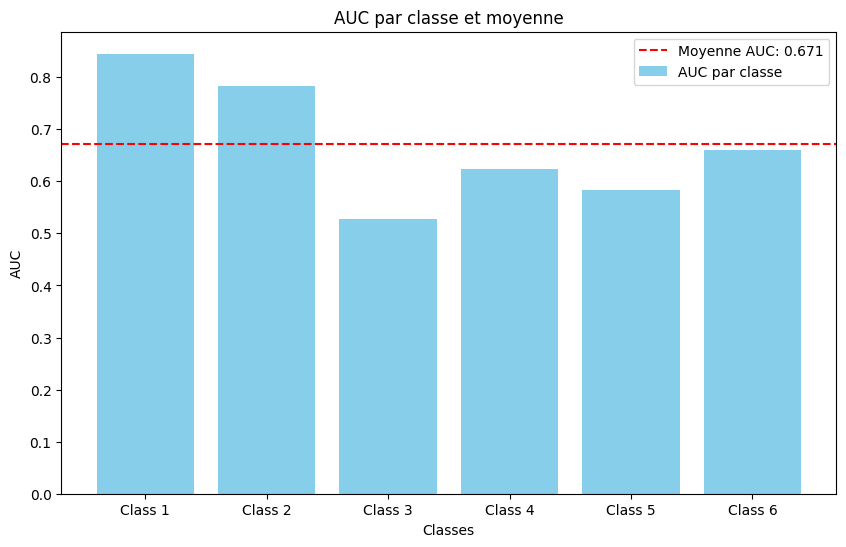

In [24]:
#@title plot AUC
auc_per_class = [0.844968077956989, 0.78347876672484, 0.5278513540666652,
                 0.6237871074468369, 0.5831940553376557, 0.660686339664265]
mean_AUC = 0.670660950199542
classes = [f'Class {i+1}' for i in range(len(auc_per_class))]
x = range(len(auc_per_class))

plt.figure(figsize=(10, 6))
plt.bar(x, auc_per_class, color='skyblue', label='AUC par classe')
plt.axhline(mean_AUC, color='red', linestyle='--', label=f'Moyenne AUC: {mean_AUC:.3f}')
plt.xticks(x, classes)
plt.xlabel('Classes')
plt.ylabel('AUC')
plt.title('AUC par classe et moyenne')
plt.legend()
plt.show()

#Essai Effecient net

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0
from torchsummary import summary

model = efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs // 2),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(num_ftrs // 2, num_ftrs // 4),
    nn.ReLU(),
    nn.Linear(num_ftrs // 4, 8)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

#Test sur la présence de cetraines images

In [58]:
import os

image_ids = df_odir_entt['ID'].tolist()
#print(image_ids)
# Vérifier quels fichiers manquent
missing_files = []
for img_id in image_ids:
    img_path = os.path.join("/content/Odir_ent/Images", f"{img_id}.jpg")
    if not os.path.exists(img_path):
        missing_files.append(img_path)

print(f"Nombre d'images manquantes : {len(missing_files)}")
print("Exemples de fichiers manquants :", missing_files[:10])


Nombre d'images manquantes : 0
Exemples de fichiers manquants : []


In [ ]:
import os
#/content/Odir_ent/Images/0_left.jpg
# Exemple de chemin d'accès pour une image
img_id = '0_left'  # Test pour une image
img_path = os.path.join("/content/Odir_ent/Images", f"{img_id}.jpg")

# Vérification si l'image existe réellement
if os.path.exists(img_path):
    print(f"L'image {img_id} existe bien : {img_path}")
else:
    print(f"L'image {img_id} n'existe pas dans le répertoire.")


L'image 0_left existe bien : /content/Odir_ent/Images/0_left.jpg


#Loss plot

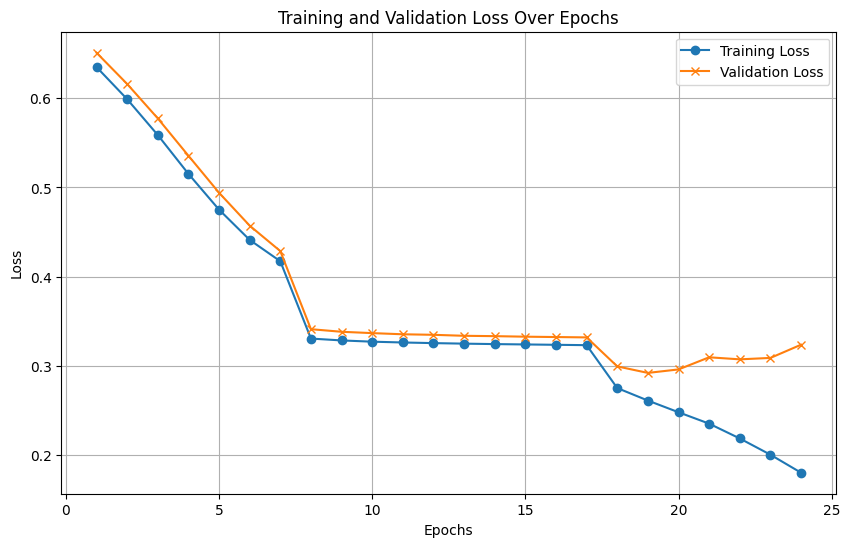

In [ ]:
epochs = list(range(1, len(train_losses) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, valid_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()